In [1]:
## setup

!pip install gym[atari]

In [0]:
## setup

import gym

from matplotlib import pyplot as plt

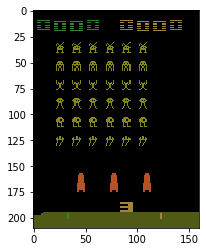

In [12]:
## environment

env = gym.make('SpaceInvaders-v0')
env.reset()
plt.imshow(env.render('rgb_array'))
plt.show()

In [22]:
print("action space", env.action_space)
print("meaning of action space", env.get_action_meanings())
print("observation space", env.observation_space)

action space Discrete(6)
meaning of action space ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space Box(210, 160, 3)
